# 1. Preparación del dataset

<Axes: >

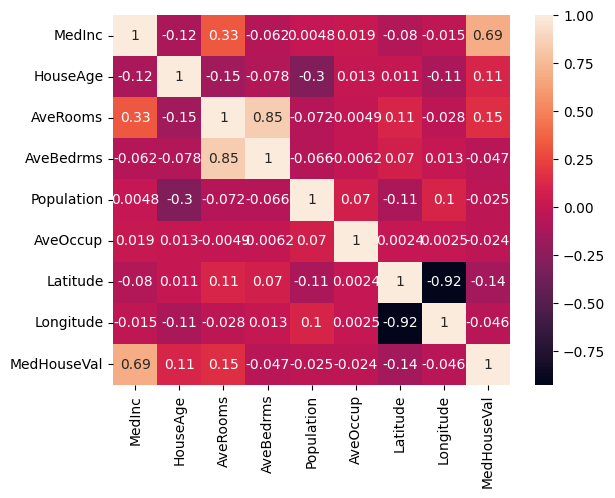

In [ ]:
import seaborn as sns
from sklearn.datasets import fetch_california_housing
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

housing = fetch_california_housing(as_frame=False)
df_housing = pd.DataFrame(housing.data, columns=housing.feature_names)
df_housing['MedHouseVal'] = housing.target
correlation=df_housing.corr()
sns.heatmap(correlation, annot=True)

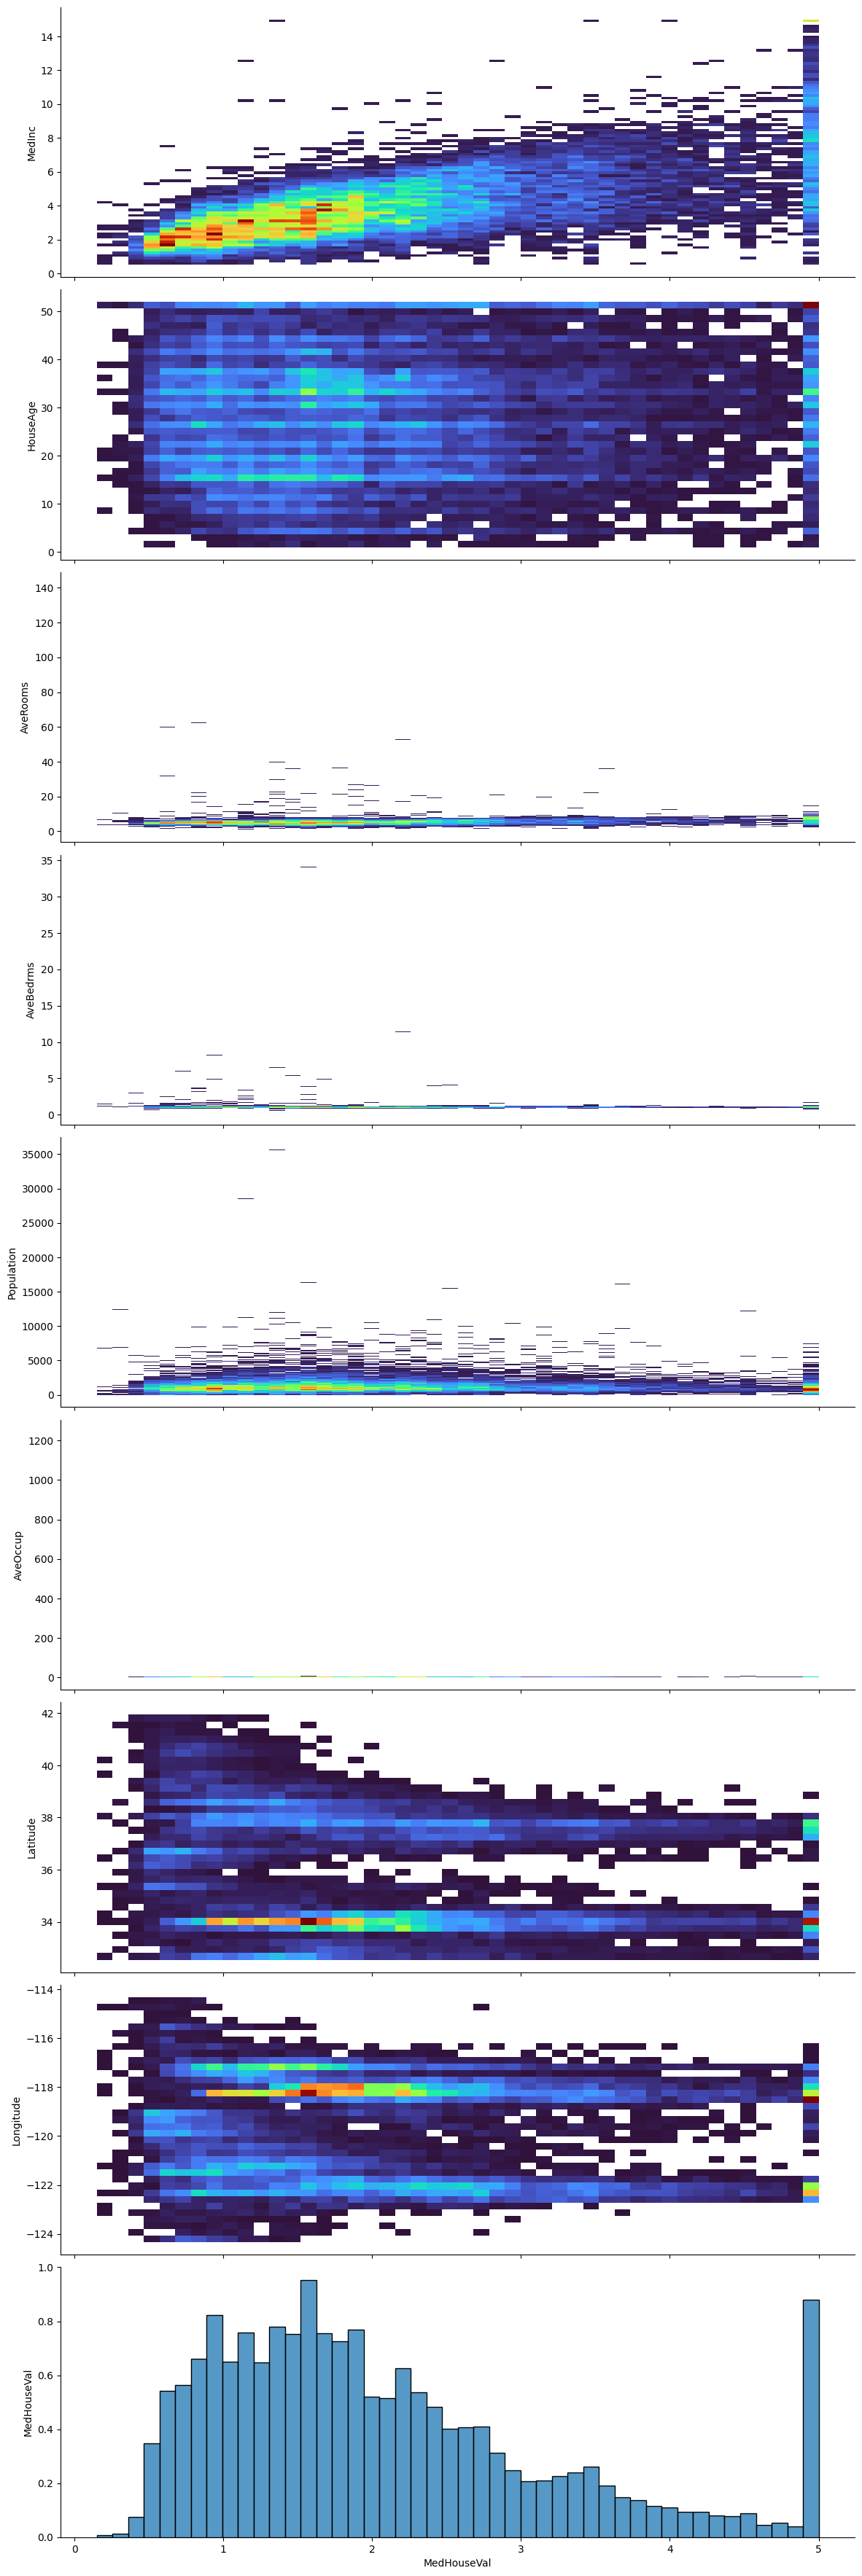

In [ ]:
g = sns.pairplot(df_housing,kind = "hist", plot_kws={'cmap': 'turbo', 'fill': True},x_vars=["MedHouseVal"], y_vars=df_housing.columns[:], height=4,  aspect=3)

In [ ]:
# quitar rooms bedrooms y occup
#df_housing = df_housing.drop(['AveRooms', 'AveBedrms', 'AveOccup'], axis=1)

## Split del dataset y normalizacion de los datos

**Normalización de datos y su importancia:**

Normalizar es una técnica estadística que escala los datos de entrada para que los atributos estén en cierto rango o escala, por ejemplo, la normalización min-max, que escala los atributos para que estén en un rango $[a,b]$ dada por la fórmula

$x'=a+\frac{x-min(x)}{max(x)-min(x)}(b-a)$

Esta técnica resulta muy útil cuando los atributos están en escalas muy distintas; además, tiene ventajas como incrementar la velocidad con la que el entrenamiento converge y reducir la sensibilidad ante las variaciones de los atributos.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import itertools
import random
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


X = df_housing.drop('MedHouseVal', axis=1).values
y = df_housing['MedHouseVal'].values.reshape(-1, 1)


# Split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42) #70% de los datos para el entrenamiento de los datos
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42) # 50% del restante (15% del total) se usa para validacion, y el 50% restante para prueba

# Dos scalers separados: uno para X y otro para y
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Ajustar y transformar usando sólo el set de entrenamiento
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled   = scaler_X.transform(X_val)
X_test_scaled  = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train)
y_val_scaled   = scaler_y.transform(y_val)
y_test_scaled  = scaler_y.transform(y_test)

# Convertir a tensores de forma eficiente
X_train = torch.from_numpy(X_train_scaled.astype(np.float32))
X_val   = torch.from_numpy(X_val_scaled.astype(np.float32))
X_test  = torch.from_numpy(X_test_scaled.astype(np.float32))

y_train = torch.from_numpy(y_train_scaled.astype(np.float32))
y_val   = torch.from_numpy(y_val_scaled.astype(np.float32))
y_test  = torch.from_numpy(y_test_scaled.astype(np.float32))

#2. Teoría e implementación

**Definición de red neuronal feed forward:**

Una red neuronal feed forward es un modelo matemático que consta de nodos interconectados. Los nodos son organizados en $L$ capas. Tomando input $x\in\mathbb R^n$ el output de cada capa viene dado por

$\mathcal N_j=\sigma_j(W_j\mathcal N_{j-1}+b_j)$

Para $1\leq j\leq L$ definimos $d_j$ como el número de nodos en cada capa y $\mathcal N_0=x$. Los pesos $W_j$ son matrices $d_j\times d_{j-1}$ con entradas en los reales, los bias o sesgos $b_j$ son vectores de $\mathbb R^{d_j}$, para $1\leq j\leq L-1$, los $\sigma_j$ son funciones de activación no lineales. Por otro lado, $\sigma_L$ es la función identidad y $b_L=0$ y $\tilde y=\mathcal N_L$ es el candidato a solución. Los pesos y bias se determinan a través de un proceso de entrenamiento para minimizar una función de pérdida $\mathcal L(u)$.

Funciones comúnmente usadas como funciones de activación no lineales son $tanh$ y $ReLu$.

En nuestro caso, como las variables de salida son reales, tenemos que

$h(x;\theta):=\mathcal N_{L-1}$ cuando $\mathcal N_0=x$, además contamos con los datos $\{(x_i,y_i)\}_{i=1}^N$, además $W^{(L)}=[w_1,\ldots,w_{d_{L-1}}]$.  Nuestra función a minimizar será

$\mathcal L(\theta)=\frac{1}{N}\sum_{j=1}^N|W^{(L)}h(x_j;\theta)-y_j|^2$

Para $1\leq j\leq N$ tenemos que $h(x_j,\theta)=\begin{bmatrix}
t_1^{(j)}\\
\vdots \\
t_{d_{L-1}}^{(L)}
\end{bmatrix}$, si $y=\begin{bmatrix}
y_1\\
\vdots \\
y_N
\end{bmatrix}$, entonces
$\mathcal L(\theta)=\frac{1}{N}\left\lVert\begin{bmatrix}
    t_1^{(1)} \ \ \ldots\ \ t_{d_{L-1}}^{(1)}\\
    \vdots \ \ \  \ \ \ \ \ \ \ \ \ \ \ \ \ \vdots\\
    t_1^{(N)} \ \ \ldots \ \ t_{d_{L-1}}^{(N)}
\end{bmatrix}\begin{bmatrix}
    w_1\\
    \vdots \\
    w_{d_{L-1}}
\end{bmatrix}-y\right\Vert^2$

Que se puede resolver como un problema de mínimos cuadráticos.

**Regresión lineal:**

La regresión lineal es un modelo matemático que estima la relación entre una variable dependiente y varias independientes, donde las relaciones son modeladas usando funciones lineales, cuyos parámetros se obtienen a partir de los datos $\{(u_i,v_i)\}_{i=1}^M$ de entrada, donde cada $u_i=(u_1^{(i)},\ldots,u_n^{(i)})\in\mathbb R^d$ y cada $v_i\in\mathbb R$.  El modelo toma la forma de.

$y_i=\beta_0+u_1^{(i)}\beta_1+\ldots+u_M^{(i)}\beta_m+\epsilon_i$


In [ ]:
class FlexibleNet(nn.Module):
    def __init__(self, n_layers, n_neurons, activation_fn, descenso_capa, minimos_cuadrados = True):
        super().__init__()
        layers = []

        in_dim = X_train.shape[1]
        # capa inicial
        layers.append(nn.Linear(in_dim, n_neurons))
        layers.append(activation_fn())

        in_dim = n_neurons
        out_dim = n_neurons
        # capas ocultas
        for _ in range(n_layers):
            layers.append(nn.Linear(in_dim, out_dim))
            layers.append(activation_fn())
            out_dim, in_dim = max(3,in_dim - descenso_capa), out_dim

        self.network = nn.Sequential(*layers)

        self.output_layer = nn.Parameter(torch.zeros(in_dim,1), requires_grad= not minimos_cuadrados) # Capa de salida, requires_grad=False para ajustar pesos manualmente con regresión lineal (como dice el enunciado)

    # Metodo que describe como fluye la informacion a traves de la red
    def forward_ocultas(self, x):
      return self.network(x) # Aplicamos las capas ocultas al tensor x

    def forward(self, x):
      return self.network(x)@self.output_layer

#Red Neuronal implementada para entrenarse unicamente usando gradiente descendente

class FlexibleNet_GD(nn.Module):
    def __init__(self, n_layers, n_neurons, activation_fn, descenso_capa):
        super().__init__()
        layers = []

        in_dim = X_train.shape[1]
        # capa inicial
        layers.append(nn.Linear(in_dim, n_neurons))
        layers.append(activation_fn())

        in_dim = n_neurons
        out_dim = n_neurons
        # capas ocultas
        for _ in range(n_layers):
            layers.append(nn.Linear(in_dim, out_dim))
            layers.append(activation_fn())
            out_dim, in_dim = max(3,in_dim - descenso_capa), out_dim

        self.network = nn.Sequential(*layers)

        self.output_layer = nn.Linear(in_dim,1) # Capa de salida, requires_grad=False para ajustar pesos manualmente con regresión lineal (como dice el enunciado)

    # Metodo que describe como fluye la informacion a traves de la red
    def forward_ocultas(self, x):
      return self.network(x) # Aplicamos las capas al tensor x

    def forward(self, x):
      x = self.network(x)
      return self.output_layer(x)


## Busqueda de hiperparametros

In [ ]:
# Rangos de búsqueda (Anotamos algunos parametros que no daban tan buenos resultados para ahorrar tiempo en pruebas posteriores)
random.seed(1)
Ncapas_values = list(range(3, 6))
NNcapa_values = list(range(32, 48, 4))
lr_values = [0.00058] #10**random.uniform(-4, -3) for _ in range(5)]  # entre 1e-4 y 1e-3
activation_values = [nn.Tanh]#, nn.ReLU] # funciones de activación
descenso_capa = [0]
#minimos_cuadrados = [True]#, False]

print("Hiperparámetros generados:")
print(f"Ncapas: {Ncapas_values}")
print(f"NNcapa: {NNcapa_values}")
print(f"Learning rates: {[round(lr,6) for lr in lr_values]}")
print(f"Activaciones: {[a.__name__ for a in activation_values]}")

# Crear todas las combinaciones posibles
combinations = list(itertools.product(Ncapas_values, NNcapa_values, lr_values, activation_values, descenso_capa))

Hiperparámetros generados:
Ncapas: [3, 4, 5]
NNcapa: [32, 36, 40, 44]
Learning rates: [0.00058]
Activaciones: ['Tanh']


In [ ]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)

## Inicio del entrenamiento

El primer entrenamiento se hace mediante gradiente descendente en sus capas ocultas y la capa de salida se resuelve de manera exacta usando minimos cuadrados.

In [ ]:
results = []
models = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for i, (n_layers, n_neurons, lr, activation_fn, descenso_capa) in enumerate(combinations, 1):
    model = FlexibleNet(n_layers, n_neurons, activation_fn, descenso_capa)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    n_epochs = 1500
    train_losses = []
    val_losses = []


    for epoch in range(n_epochs):
        # ---- Entrenamiento
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()


        # Recalcular W_out con mínimos cuadrados (ECM)

        with torch.no_grad():
          H = model.forward_ocultas(X_train)
          model.output_layer[:] = torch.linalg.lstsq(H, y_train).solution

        # ---- Validación
        model.eval()
        with torch.no_grad():
            val_output = model(X_val)
            val_loss = criterion(val_output, y_val)

        train_losses.append(loss.item())
        val_losses.append(val_loss.item())

    # Validación final
    val_loss_final = val_losses[-1]

    results.append({
        "modelo": i-1,
        "Ncapas": n_layers,
        "NNcapa": n_neurons,
        "LR": lr,
        "Activación": activation_fn.__name__,
        "Val_Loss": val_loss_final,
        "train_losses": train_losses,
        "val_losses": val_losses,
        "descenso_capa": descenso_capa,
        #"minimos_cuadrados": minimos_cuadrados
    })

    models.append(model)

    print(f"[{i-1}/{len(combinations)-1}] Ncapas={n_layers}, NNcapa={n_neurons}, LR={lr:.6f}, Act={activation_fn.__name__}, Val_Loss={val_loss_final:.4f}, descenso_capa={descenso_capa}, minimos_cuadrados={minimos_cuadrados}")

[0/11] Ncapas=3, NNcapa=32, LR=0.000580, Act=Tanh, Val_Loss=0.2321, descenso_capa=0, minimos_cuadrados=True
[1/11] Ncapas=3, NNcapa=36, LR=0.000580, Act=Tanh, Val_Loss=0.2281, descenso_capa=0, minimos_cuadrados=True
[2/11] Ncapas=3, NNcapa=40, LR=0.000580, Act=Tanh, Val_Loss=0.2321, descenso_capa=0, minimos_cuadrados=True
[3/11] Ncapas=3, NNcapa=44, LR=0.000580, Act=Tanh, Val_Loss=0.2417, descenso_capa=0, minimos_cuadrados=True
[4/11] Ncapas=4, NNcapa=32, LR=0.000580, Act=Tanh, Val_Loss=0.2400, descenso_capa=0, minimos_cuadrados=True
[5/11] Ncapas=4, NNcapa=36, LR=0.000580, Act=Tanh, Val_Loss=0.2308, descenso_capa=0, minimos_cuadrados=True
[6/11] Ncapas=4, NNcapa=40, LR=0.000580, Act=Tanh, Val_Loss=0.2277, descenso_capa=0, minimos_cuadrados=True
[7/11] Ncapas=4, NNcapa=44, LR=0.000580, Act=Tanh, Val_Loss=0.2234, descenso_capa=0, minimos_cuadrados=True
[8/11] Ncapas=5, NNcapa=32, LR=0.000580, Act=Tanh, Val_Loss=0.2296, descenso_capa=0, minimos_cuadrados=True
[9/11] Ncapas=5, NNcapa=36, 

En el segundo entrenamiento se usa solo gradiente descendente para hacer la comparacion de las distintas configuraciones de la red neuronal

In [ ]:
results_GD = []
models_GD = []

for i, (n_layers, n_neurons, lr, activation_fn, descenso_capa) in enumerate(combinations, 1):
    model = FlexibleNet_GD(n_layers, n_neurons, activation_fn, descenso_capa)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    n_epochs = 1500
    train_losses = []
    val_losses = []


    for epoch in range(n_epochs):
        # ---- Entrenamiento
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()

        # ---- Validación
        model.eval()
        with torch.no_grad():
            val_output = model(X_val)
            val_loss = criterion(val_output, y_val)

        train_losses.append(loss.item())
        val_losses.append(val_loss.item())

    # Validación final
    val_loss_final = val_losses[-1]

    results_GD.append({
        "modelo": i-1,
        "Ncapas": n_layers,
        "NNcapa": n_neurons,
        "LR": lr,
        "Activación": activation_fn.__name__,
        "Val_Loss": val_loss_final,
        "train_losses": train_losses,
        "val_losses": val_losses,
        "descenso_capa": descenso_capa
    })

    models_GD.append(model)

    print(f"[{i-1}/{len(combinations)-1}] Ncapas={n_layers}, NNcapa={n_neurons}, LR={lr:.6f}, Act={activation_fn.__name__}, Val_Loss={val_loss_final:.4f}, descenso_capa={descenso_capa}")


[0/11] Ncapas=3, NNcapa=32, LR=0.000580, Act=Tanh, Val_Loss=0.2229, descenso_capa=0
[1/11] Ncapas=3, NNcapa=36, LR=0.000580, Act=Tanh, Val_Loss=0.2172, descenso_capa=0
[2/11] Ncapas=3, NNcapa=40, LR=0.000580, Act=Tanh, Val_Loss=0.2183, descenso_capa=0
[3/11] Ncapas=3, NNcapa=44, LR=0.000580, Act=Tanh, Val_Loss=0.2224, descenso_capa=0
[4/11] Ncapas=4, NNcapa=32, LR=0.000580, Act=Tanh, Val_Loss=0.2127, descenso_capa=0
[5/11] Ncapas=4, NNcapa=36, LR=0.000580, Act=Tanh, Val_Loss=0.2213, descenso_capa=0
[6/11] Ncapas=4, NNcapa=40, LR=0.000580, Act=Tanh, Val_Loss=0.2222, descenso_capa=0
[7/11] Ncapas=4, NNcapa=44, LR=0.000580, Act=Tanh, Val_Loss=0.2204, descenso_capa=0
[8/11] Ncapas=5, NNcapa=32, LR=0.000580, Act=Tanh, Val_Loss=0.2215, descenso_capa=0
[9/11] Ncapas=5, NNcapa=36, LR=0.000580, Act=Tanh, Val_Loss=0.2254, descenso_capa=0
[10/11] Ncapas=5, NNcapa=40, LR=0.000580, Act=Tanh, Val_Loss=0.2234, descenso_capa=0
[11/11] Ncapas=5, NNcapa=44, LR=0.000580, Act=Tanh, Val_Loss=0.2223, descen

# Análisis de resultados

In [ ]:
df_results = pd.DataFrame(results).sort_values(by="Val_Loss", ascending=True)
df_results_GD = pd.DataFrame(results_GD).sort_values(by="Val_Loss", ascending=True)

print("\nMEJOR CONFIGURACIÓN RED 1:")
print(df_results.head(1)[["Ncapas", "NNcapa", "LR", "Activación", "Val_Loss"]])

print("\nMEJOR CONFIGURACIÓN RED 2:")
print(df_results_GD.head(1)[["Ncapas", "NNcapa", "LR", "Activación", "Val_Loss"]])

print("\nTOP 10 CONFIGURACIONES RED 1:")
print(df_results.head(10)[["modelo", "Ncapas", "NNcapa", "LR", "Activación", "Val_Loss"]].to_string(index=False))

print("\nTOP 10 CONFIGURACIONES RED 2:")
print(df_results_GD.head(10)[["modelo", "Ncapas", "NNcapa", "LR", "Activación", "Val_Loss"]].to_string(index=False))


MEJOR CONFIGURACIÓN RED 1:
   Ncapas  NNcapa       LR Activación  Val_Loss
7       4      44  0.00058       Tanh  0.223364

MEJOR CONFIGURACIÓN RED 2:
   Ncapas  NNcapa       LR Activación  Val_Loss
4       4      32  0.00058       Tanh  0.212705

TOP 10 CONFIGURACIONES RED 1:
 modelo  Ncapas  NNcapa      LR Activación  Val_Loss
      7       4      44 0.00058       Tanh  0.223364
      6       4      40 0.00058       Tanh  0.227657
      1       3      36 0.00058       Tanh  0.228095
     11       5      44 0.00058       Tanh  0.229009
      8       5      32 0.00058       Tanh  0.229555
      5       4      36 0.00058       Tanh  0.230806
      2       3      40 0.00058       Tanh  0.232065
      0       3      32 0.00058       Tanh  0.232103
      9       5      36 0.00058       Tanh  0.235182
      4       4      32 0.00058       Tanh  0.239968

TOP 10 CONFIGURACIONES RED 2:
 modelo  Ncapas  NNcapa      LR Activación  Val_Loss
      4       4      32 0.00058       Tanh  0.212705
 

In [ ]:
model = models[df_results.iloc[0,0]]
y_pred = model(X_test)

mse_test = ((y_pred - y_test)**2).mean()
print(f"MSE en el conjunto de prueba: {mse_test:.4f}")

y_pred_escalado = scaler_y.inverse_transform(y_pred.detach().numpy())
y_test_escalado = scaler_y.inverse_transform(y_test.numpy())

#convertir a torch los escalados
#y_pred_escalado = torch.from_numpy(y_pred_escalado)
#y_test_escalado = torch.from_numpy(y_test_escalado)

df_ResultadosTest = pd.DataFrame({"y_test": y_test_escalado.flatten(), "y_pred": y_pred_escalado.flatten()})
df_ResultadosTest.tail(10)



MSE en el conjunto de prueba: 0.2132


,y_test,y_pred
3086,3.440,3.574506
3087,4.381,3.951440
3088,0.658,0.725816
3089,1.366,1.632362
3090,2.212,1.833960
3091,2.865,2.885768
3092,3.477,3.895164
3093,1.013,0.969624
3094,1.014,1.434168
3095,3.031,2.639162


#3. Análisis y visualización

Grafico de la Red Neuronal

In [ ]:
def plot_neural_network(input_data_size, num_hidden_layers, neurons_per_hidden_layer, node_radius=0.03):
    """
    Muestra gráficamente una red neuronal con conexiones que inician en el borde de los nodos.

    Args:
        input_data_size (int): El número de nodos en la capa de entrada.
        num_hidden_layers (int): El número de capas ocultas.
        neurons_per_hidden_layer (list): Una lista con el número de neuronas
                                          en cada capa oculta.
        node_radius (float): Radio de los círculos que representan las neuronas.
    """
    if len(neurons_per_hidden_layer) != num_hidden_layers:
        raise ValueError("La longitud de 'neurons_per_hidden_layer' debe ser igual a 'num_hidden_layers'.")

    # Definición de capas y configuración inicial
    layer_sizes = [input_data_size] + neurons_per_hidden_layer + [1]
    max_neurons=max(layer_sizes)
    v_spacing = 0.8 / (max_neurons + 1)

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_title("Visualización de Red Neuronal", fontsize=14)
    ax.axis('off')

    layer_x_positions = np.linspace(0.1, 0.9, len(layer_sizes)) # Ajuste para mejor espaciado

    neurons_centers = [] # Lista para guardar las coordenadas centrales de todas las neuronas

    # --- 1. Calcular y almacenar las coordenadas de los centros de las neuronas ---
    for i, num_neurons in enumerate(layer_sizes):
        # Centrar las neuronas verticalmente
        if num_neurons == 1:
            y_coords = [0.5]
        else:
            y_coords = np.linspace(0.5 - (num_neurons - 1) * v_spacing / 2, 0.5 + (num_neurons - 1) * v_spacing / 2, num_neurons)

        layer_coords = []
        for y_coord in y_coords:
            layer_coords.append((layer_x_positions[i], y_coord))
            neurons_centers.append((layer_x_positions[i], y_coord))

        # Etiquetar las capas (posición en el eje Y ajustada)
        if i == 0:
            layer_label = "Entrada"
        elif i == len(layer_sizes) - 1:
            layer_label = "Salida"
        else:
            layer_label = f"Oculta {i}"

        ax.text(layer_x_positions[i], 0.95, layer_label, ha='center', va='bottom', fontsize=12, fontweight='bold')

    # --- 2. Dibujar CONEXIONES (Líneas) ---
    current_neuron_idx = 0
    for i in range(len(layer_sizes) - 1):
        num_neurons_prev_layer = layer_sizes[i]
        num_neurons_current_layer = layer_sizes[i+1]

        # Obtener coordenadas de los centros de las capas adyacentes
        prev_layer_coords = neurons_centers[current_neuron_idx : current_neuron_idx + num_neurons_prev_layer]
        current_neuron_idx += num_neurons_prev_layer
        current_layer_coords = neurons_centers[current_neuron_idx : current_neuron_idx + num_neurons_current_layer]

        for x1, y1 in prev_layer_coords:
            for x2, y2 in current_layer_coords:

                # CÁLCULO DEL DESPLAZAMIENTO (Trigonometría)
                dx = x2 - x1
                dy = y2 - y1
                dist = np.sqrt(dx**2 + dy**2)

                unit_dx = dx / dist
                unit_dy = dy / dist

                x_start = x1 + node_radius * unit_dx
                y_start = y1 + node_radius * unit_dy
                x_end = x2 - node_radius * unit_dx
                y_end = y2 - node_radius * unit_dy

                # Dibujar la línea entre los nuevos puntos
                ax.plot([x_start, x_end], [y_start, y_end], 'k-', alpha=0.2, lw=0.5)


    # --- 3. Dibujar NEURONAS (Círculos) POR ENCIMA ---
    current_neuron_idx = 0
    for i, num_neurons in enumerate(layer_sizes):

        # Coordenadas de la capa actual
        layer_coords = neurons_centers[current_neuron_idx : current_neuron_idx + num_neurons]
        current_neuron_idx += num_neurons

        for j, (x_coord, y_coord) in enumerate(layer_coords):

            # Definir color según la capa
            if i == 0:
                color = 'blue'
            elif i == len(layer_sizes) - 1:
                color = 'red'
            else:
                color = 'green'

            # Dibujar el círculo
            circle = plt.Circle((x_coord, y_coord), node_radius, color=color, ec='black', lw=1.5, zorder=3) # zorder=3 asegura que esté arriba
            ax.add_artist(circle)

            # Añadir número/etiqueta
            if i == 0:
                ax.text(x_coord - node_radius - 0.005, y_coord, f'X{j+1}', va='center', ha='right', fontsize=9)
            elif i == len(layer_sizes) - 1:
                ax.text(x_coord + node_radius + 0.005, y_coord, f'Y{j+1}', va='center', ha='left', fontsize=9)
            else:
                ax.text(x_coord + node_radius + 0.005, y_coord, f'H{i},{j+1}', va='center', ha='left', fontsize=9)

    # Ajustar límites y mostrar
    ax.set_xlim(0.0, 1.0)
    ax.set_ylim(0.0, 1.0)
    plt.show()

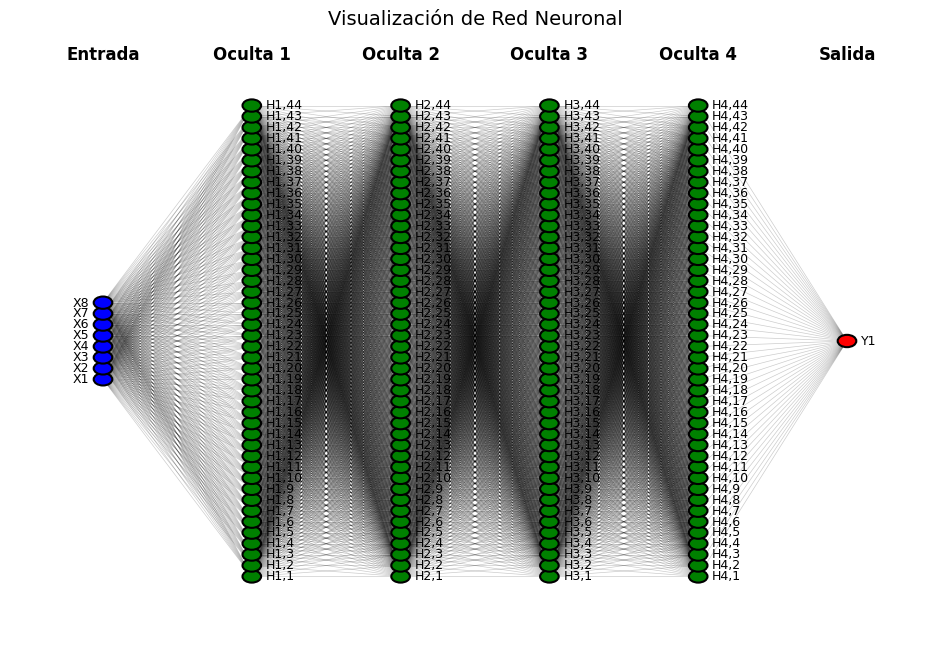

In [ ]:
plot_neural_network(8,int(df_results.iloc[0,1]),[int(df_results.iloc[0,2])]*int(df_results.iloc[0,1]),0.01)

##Ejecucion de las Redes Neuronales en el Conjunto de Prueba

In [ ]:
model = models[df_results.iloc[0,0]]
model_GD= models_GD[df_results_GD.iloc[0,0]]
y_pred = model(X_test)
y_pred_GD = model_GD(X_test)

y_pred_escalado = scaler_y.inverse_transform(y_pred.detach().numpy())
y_pred_escalado_GD = scaler_y.inverse_transform(y_pred_GD.detach().numpy())
y_test_escalado = scaler_y.inverse_transform(y_test.numpy())

#convertir a torch los escalados
y_pred_escalado = torch.from_numpy(y_pred_escalado)
y_test_escalado = torch.from_numpy(y_test_escalado)



##Modelo de Regresion Usando Minimos Cuadrados

In [ ]:
from sklearn.linear_model import LinearRegression
modelo_regresion = LinearRegression()

# Entrenar el modelo (Encontrar los parámetros Beta con Mínimos Cuadrados)
modelo_regresion.fit(X_train, y_train)

# Coeficientes (Betas, b1 a bp)
coeficientes = modelo_regresion.coef_
# Intercepto (Beta 0)
intercepto = modelo_regresion.intercept_

print(f"Intercepto (β₀): {intercepto}")
print(f"Coeficientes (β₁ a βp): {coeficientes}")

r_cuadrado = modelo_regresion.score(X_test, y_test)

Intercepto (β₀): [-9.214757e-09]
Coeficientes (β₁ a βp): [[ 7.3369938e-01  1.0550697e-01 -2.5880831e-01  3.0101418e-01
  -7.6414645e-04 -3.6025867e-02 -7.7226150e-01 -7.5045550e-01]]


##Comparacion de Resultados

In [ ]:
y_regresion=modelo_regresion.predict(X_test)

y_regresion_escalado = scaler_y.inverse_transform(y_regresion)
df_ResultadosTest = pd.DataFrame({"y_test": y_test_escalado.flatten(), "y_pred1": y_pred_escalado.detach().flatten(),"y_pred2": y_pred_escalado_GD.flatten(),'y_regre': y_regresion_escalado.flatten()})
df_ResultadosTest.head(100)

,y_test,y_pred1,y_pred2,y_regre
0,1.000,0.700858,0.844658,1.386084
1,1.188,1.003041,1.096599,0.806202
2,3.761,3.006814,3.273926,2.039045
3,2.000,0.780049,1.551624,2.318828
4,0.952,1.502435,1.164430,1.950201
...,...,...,...,...
95,1.588,1.774366,1.526955,1.764954
96,1.227,1.347867,1.299366,1.413395
97,2.103,2.286302,2.228368,2.449383
98,1.301,1.326144,1.393677,1.794020


In [ ]:
print(model,model_GD)

FlexibleNet(
  (network): Sequential(
    (0): Linear(in_features=8, out_features=44, bias=True)
    (1): Tanh()
    (2): Linear(in_features=44, out_features=44, bias=True)
    (3): Tanh()
    (4): Linear(in_features=44, out_features=44, bias=True)
    (5): Tanh()
    (6): Linear(in_features=44, out_features=44, bias=True)
    (7): Tanh()
    (8): Linear(in_features=44, out_features=44, bias=True)
    (9): Tanh()
  )
) FlexibleNet_GD(
  (network): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): Tanh()
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): Tanh()
    (8): Linear(in_features=32, out_features=32, bias=True)
    (9): Tanh()
  )
  (output_layer): Linear(in_features=32, out_features=1, bias=True)
)


In [ ]:
Modelos=['y_pred1','y_pred2','y_regre']

R2=[]
RMSE=[]
MAE=[]

#Se calcula R^2, MSE, RMSE y MAE para ambas redes y el modelo de regresión lineal
for i in Modelos:
    r2 = r2_score(df_ResultadosTest['y_test'].values, df_ResultadosTest[i].values)
    mse = mean_squared_error(df_ResultadosTest['y_test'].values, df_ResultadosTest[i].values)
    rmse=(mse)**(1/2)
    mae = mean_absolute_error(df_ResultadosTest['y_test'].values, df_ResultadosTest[i].values)
    R2.append(r2)
    RMSE.append(rmse)
    MAE.append(mae)

#Se crea el dataframe que reune toda la información calculada
Comparaciones = pd.DataFrame({
    'Modelo': Modelos,
    'R2': R2,
    'RMSE': RMSE,
    'MAE': MAE
})

#Se renombran las filas de los modelos para que tengan un nombre más descriptivo
Comparaciones['Modelo'] = Comparaciones['Modelo'].replace({
    'y_pred1': 'NN Híbrida (a)',
    'y_pred2': 'NN GD Completa (b)',
    'y_regre': 'Modelo Lineal (c)'
})

#Se renombran las columnas
Comparaciones.columns = [
    'Modelo',
    'Coeficiente de Determinación ($R^2$)',
    'Raíz del Error Cuadrático Medio (RMSE)',
    'Error Absoluto Medio (MAE)'
]

#Se muestra la tabla
Comparaciones.head()

,Modelo,Coeficiente de Determinación ($R^2$),Raíz del Error Cuadrático Medio (RMSE),Error Absoluto Medio (MAE)
0,NN Híbrida (a),0.784046,0.534376,0.362031
1,NN GD Completa (b),0.812570,0.497836,0.345109
2,Modelo Lineal (c),0.606552,0.721291,0.521043


La red entrenada completamente por gradiente descendiente tiene un  R2  ligeramente mayor a la hibrida y superior a la regresión lineal, similarmente tiene un RMSE y MAE ligeramente menor al de la red hibrida y muchisimo más bajo que el modelo lineal, esto nos permite concluir que la red entrenada puramente por gradiente descendiente es mejor que el modelo lineal y apenas superior que la hibrida. El desempeño de las redes neuronales respecto al del modelo lineal valida su uso por encima de este.

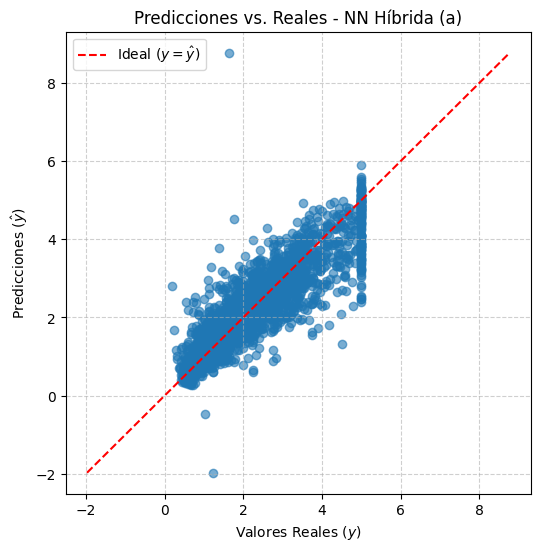

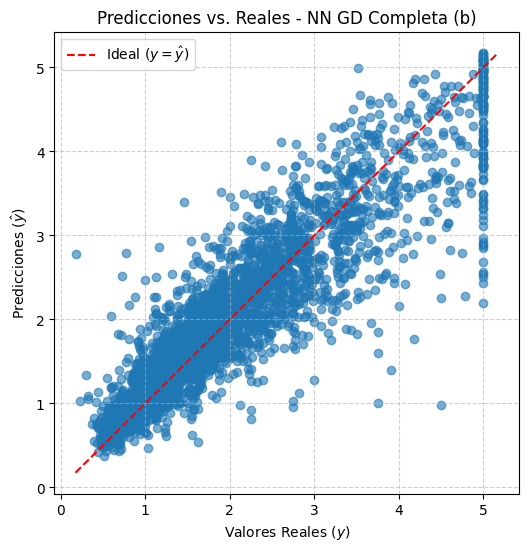

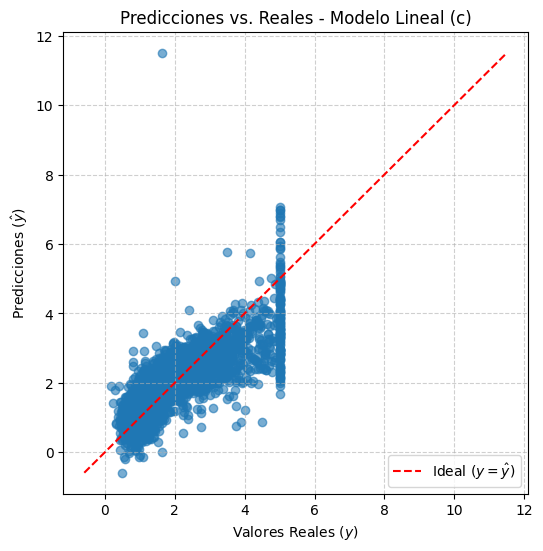

In [ ]:
def plot_predictions_vs_actual(df, y_true_col, y_pred_col, model_name):
    """Genera el gráfico de dispersión de predicciones vs. valores reales."""
    plt.figure(figsize=(6, 6))
    plt.scatter(df[y_true_col], df[y_pred_col], alpha=0.6)

    # Línea de referencia y = x
    min_val = min(df[y_true_col].min(), df[y_pred_col].min())
    max_val = max(df[y_true_col].max(), df[y_pred_col].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label=r'Ideal ($y = \hat{y}$)')

    plt.title(f'Predicciones vs. Reales - {model_name}')
    plt.xlabel('Valores Reales ($y$)')
    plt.ylabel(r'Predicciones ($\hat{y}$)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

plot_predictions_vs_actual(df_ResultadosTest, 'y_test', 'y_pred1', 'NN Híbrida (a)')
plot_predictions_vs_actual(df_ResultadosTest, 'y_test', 'y_pred2', 'NN GD Completa (b)')
plot_predictions_vs_actual(df_ResultadosTest, 'y_test', 'y_regre', 'Modelo Lineal (c)')

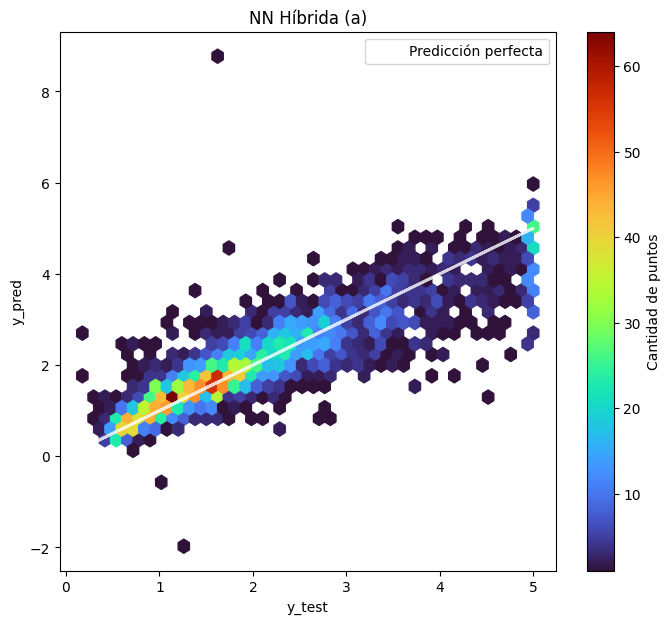

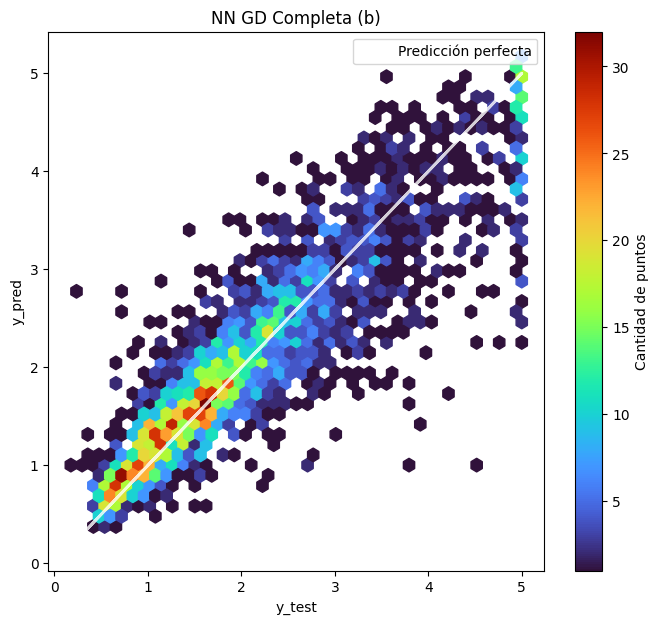

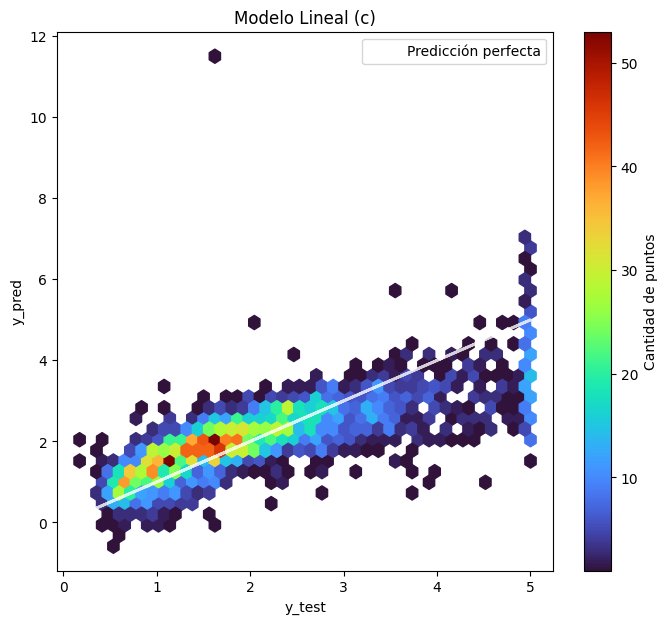

In [ ]:
def plot_predictions_vs_actual_hexbin(df, y_true_col, y_pred_col, model_name):
    plt.figure(figsize=(8,7))
    plt.plot(
        df[y_true_col], df[y_true_col],
        color='white', linewidth=2, alpha=0.8, label="Predicción perfecta"
    )
    plt.hexbin(
        df[y_true_col], df[y_pred_col],
        gridsize=40, cmap='turbo', mincnt=1
    )
    plt.xlabel("y_test")
    plt.ylabel("y_pred")
    plt.colorbar(label="Cantidad de puntos")
    plt.legend()
    plt.title(f"{model_name}")
    plt.show()

plot_predictions_vs_actual_hexbin(df_ResultadosTest, 'y_test', 'y_pred1', 'NN Híbrida (a)')
plot_predictions_vs_actual_hexbin(df_ResultadosTest, 'y_test', 'y_pred2', 'NN GD Completa (b)')
plot_predictions_vs_actual_hexbin(df_ResultadosTest, 'y_test', 'y_regre', 'Modelo Lineal (c)')

En el caso de las redes neuronales los puntos se agrupan de forma densa y cercana a la recta ideal. El modelo lineal tiene un poco más de dispersión y tienda a subestimar y sobreestimar los valores altos y bajos respectivamente. La red neuronal que solo usa gradiente descendiente compactifica mejor los puntos que la hibrida

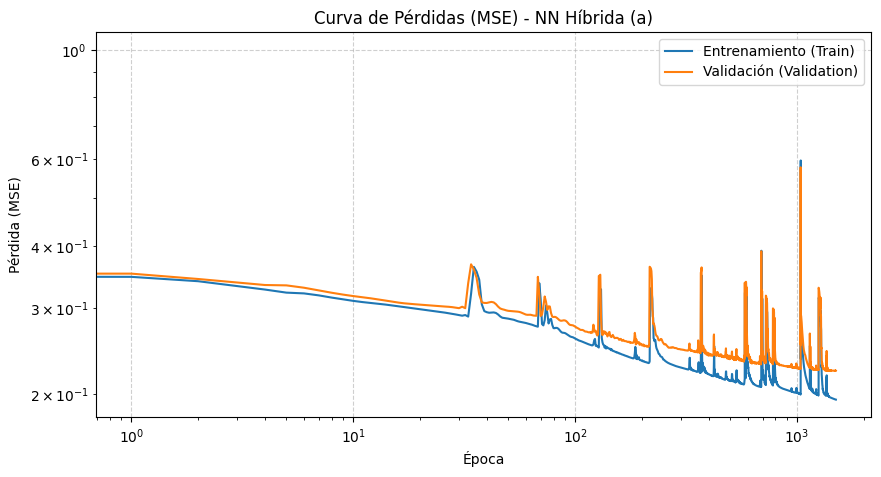

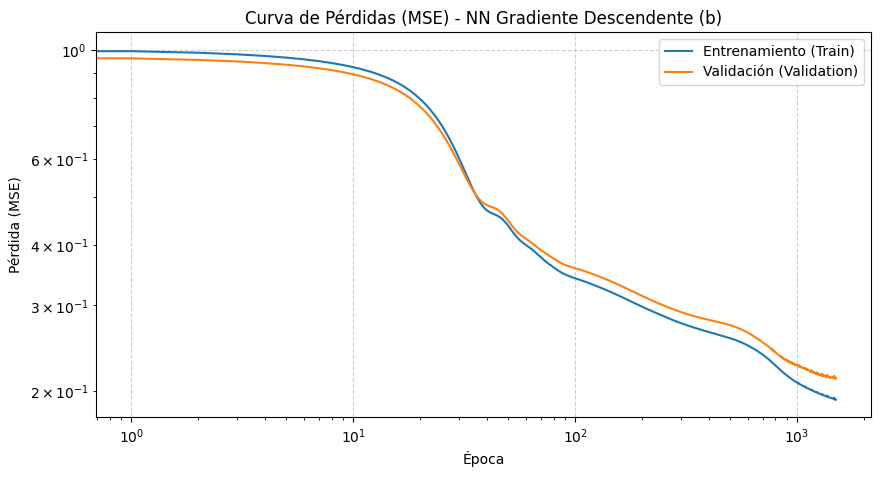

In [ ]:
def plot_loss_curve(history, model_name):
    """Genera la curva de pérdida de entrenamiento y validación."""
    plt.figure(figsize=(10, 5))
    plt.plot(history['train_losses'], label='Entrenamiento (Train)')
    plt.plot(history['val_losses'], label='Validación (Validation)')
    plt.title(f'Curva de Pérdidas (MSE) - {model_name}')
    plt.xlabel('Época')
    plt.ylabel('Pérdida (MSE)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    #Añadir escala log-log
    plt.xscale("log")  # eje X log
    plt.yscale("log")  # eje Y log
    plt.show()

#Se guarda el mejor modelo hibrido por Val_Loss para imprimirlo
best_hybrid_result = df_results.loc[df_results['Val_Loss'].idxmin()]
best_hybrid_history = {
    'train_losses': best_hybrid_result['train_losses'],
    'val_losses': best_hybrid_result['val_losses']
}

#Se guarda el mejor modelo GD por Val_Loss para imprimirlo
best_gd_result = df_results_GD.loc[df_results_GD['Val_Loss'].idxmin()]
best_gd_history = {
    'train_losses': best_gd_result['train_losses'],
    'val_losses': best_gd_result['val_losses']
}

#Se plotean las curvas de perdida
plot_loss_curve(best_hybrid_history, 'NN Híbrida (a)')
plot_loss_curve(best_gd_history, 'NN Gradiente Descendente (b)')

En ambos casos se puede ver una excelente generalización y bajo riesgo de sobreajuste, sin embargo, la red hibrida tiende a tener picos de inestabilidad a través de todas las epocas, mientras que la curva de la red que solo usa gradiente descedente es suave y estable.

Habiendo analizado estos 3 aspectos se puede concluir que las redes son superiores al modelo lineal y se justifica su uso, al comparar la red hibrida contra la pura, la segunda tiene un desempeño ligeramente mayor, pero más importante una mayor estabilidad

#4. Conclusiones
Al analizar las distintas variantes para la solucion del problema notamos que la alternativa de realizar una red neuronal si ofrece una mayor extactitud que un modelo lineal. Ademas, entre las dos formas de entrenamiento propuestas, las soluciones finales son similares, al igual que la excatitud en la prediccion, sin embargo, en el desarrollo de la actividad se pudo observar que la Red Neurunal que resuelve de manera analitica la ultima capa (NN hibrida) es significativamente mas costosa computacionalmente que la Red convencional (NN entrenada completamente con gradiente descendente), mostrando asi que la primera opcion no ofrece ventajas significativas con respecto a la segunda, siendo mas costosa de ejecutar.
Adicionalmente se evaluo el efecto de la eliminacion del sesgo en la ejecucion de las redes neuronales. Haciendo la misma prueba ejecutada anteriormente pero eliminando el sesgo en capa capa de la red se obtuvieron disminuciones en la exactitud de los resultados finales, ademas, dicha eliminacion no ofrece ventajas significativas en terminos del costo computacional. De lo anterior, podemos concluir que la implementacion del sesgo es mas provechosa para el buen funcionamiento de una red neuronal.
La normalizacion de los datos fue un paso clave para obtener un mejor desempeño en la red neuronal, al introducir valores sin normalizar en el proceso de entrenamiento se obtuvieron valores de perdida mucho mayores, llegando a ser el doble de los que se obtuvieron con las entradas normalizadas.

# Parte 2: Códigos de clase

# 🧮 Métodos Iterativos: Jacobi, Gauss-Seidel y SOR  

En esta sección presentamos la implementación de los métodos iterativos vistos en clase (Semana 4 y 5):  

- **Jacobi**  
- **Gauss–Seidel**  
- **SOR** (*Successive Over-Relaxation*)  

Cada método sigue exactamente las fórmulas del material de clase,  
y se detiene cuando se cumple el criterio:

$$
\frac{ \| x^{(k)} - x^{(k-1)} \|_\infty }{ \| x^{(k)} \|_\infty } \leq \text{tol}
$$


In [ ]:
from typing import Tuple, Dict, Optional
import numpy as np

def _check_matrix(A: np.ndarray, b: np.ndarray):
    """Verifica dimensiones y compatibilidad de A y b."""
    A = np.asarray(A, dtype=float)
    b = np.asarray(b, dtype=float)
    if A.ndim != 2 or A.shape[0] != A.shape[1]:
        raise ValueError("A debe ser una matriz cuadrada (n x n).")
    if b.ndim != 1 or b.shape[0] != A.shape[0]:
        raise ValueError("b debe ser un vector de longitud n (compatible con A).")
    return A, b

def _stop_criterion(x_new: np.ndarray, x_old: np.ndarray, tol: float) -> bool:
    """Criterio de parada ||x^(k) - x^(k-1)||_∞ / ||x^(k)||_∞ <= tol"""
    num = np.linalg.norm(x_new - x_old, ord=np.inf)
    den = np.linalg.norm(x_new, ord=np.inf)
    if den == 0.0:
        return num <= tol
    return (num / den) <= tol

## 🔹 Método de Jacobi

De acuerdo con la **Semana 4, pág. 4**, Jacobi actualiza cada componente de manera independiente:

$$
x_i^{(k)} = \frac{1}{a_{ii}} \left( - \sum_{j \neq i} a_{ij} x_j^{(k-1)} + b_i \right)
$$

Usa únicamente los valores anteriores $$x^{(k-1)}.$$

In [ ]:
def jacobi(A: np.ndarray,
           b: np.ndarray,
           x0: Optional[np.ndarray] = None,
           tol: float = 1e-8,
           maxiter: int = 1000) -> Tuple[np.ndarray, Dict]:
    """Método de Jacobi."""
    A, b = _check_matrix(A, b)
    n = A.shape[0]
    x_old = np.zeros(n) if x0 is None else np.asarray(x0, dtype=float).copy()
    if np.any(np.diag(A) == 0):
        raise ValueError("A tiene elementos diagonales nulos; Jacobi no es aplicable.")
    x_new = np.zeros_like(x_old)

    for k in range(1, maxiter + 1):
        for i in range(n):
            aii = A[i, i]
            s = np.dot(A[i, :], x_old) - aii * x_old[i]
            x_new[i] = (-s + b[i]) / aii
        if _stop_criterion(x_new, x_old, tol):
            res_norm = np.linalg.norm(A.dot(x_new) - b, ord=np.inf)
            return x_new, {'converged': True, 'iterations': k, 'residual_norm': float(res_norm)}
        x_old[:] = x_new
    res_norm = np.linalg.norm(A.dot(x_new) - b, ord=np.inf)
    return x_new, {'converged': False, 'iterations': maxiter, 'residual_norm': float(res_norm)}

## 🔹 Método de Gauss–Seidel

Según **Semana 4, pág. 5**, Gauss–Seidel usa los valores más recientes disponibles:

$$
x_i^{(k)} = \frac{1}{a_{ii}} \left( - \sum_{j=1}^{i-1} a_{ij} x_j^{(k)}
- \sum_{j=i+1}^{n} a_{ij} x_j^{(k-1)} + b_i \right)
$$

Es decir, aprovecha cada actualización tan pronto como está disponible.

In [ ]:
def gauss_seidel(A: np.ndarray,
                 b: np.ndarray,
                 x0: Optional[np.ndarray] = None,
                 tol: float = 1e-8,
                 maxiter: int = 1000) -> Tuple[np.ndarray, Dict]:
    """Método de Gauss–Seidel."""
    A, b = _check_matrix(A, b)
    n = A.shape[0]
    x = np.zeros(n) if x0 is None else np.asarray(x0, dtype=float).copy()
    if np.any(np.diag(A) == 0):
        raise ValueError("A tiene elementos diagonales nulos; Gauss–Seidel no es aplicable.")

    for k in range(1, maxiter + 1):
        x_old = x.copy()
        for i in range(n):
            aii = A[i, i]
            s1 = np.dot(A[i, :i], x[:i]) if i > 0 else 0.0
            s2 = np.dot(A[i, i+1:], x_old[i+1:]) if i < n-1 else 0.0
            x[i] = (- (s1 + s2) + b[i]) / aii
        if _stop_criterion(x, x_old, tol):
            res_norm = np.linalg.norm(A.dot(x) - b, ord=np.inf)
            return x, {'converged': True, 'iterations': k, 'residual_norm': float(res_norm)}
    res_norm = np.linalg.norm(A.dot(x) - b, ord=np.inf)
    return x, {'converged': False, 'iterations': maxiter, 'residual_norm': float(res_norm)}

## 🔹 Método SOR (Successive Over-Relaxation)

De la **Semana 5, pág. 12**, el método SOR introduce un parámetro de relajación ω:

$$
x_i^{(k)} = (1 - \omega) x_i^{(k-1)} +
\frac{\omega}{a_{ii}} \left( - \sum_{j=1}^{i-1} a_{ij} x_j^{(k)}
- \sum_{j=i+1}^{n} a_{ij} x_j^{(k-1)} + b_i \right)
$$

- Si \( \omega = 1 \) → se reduce a Gauss–Seidel.  
- Si \( \omega > 1 \) → puede **acelerar la convergencia**, pero solo dentro de \( (0,2) \).

In [ ]:
def sor(A: np.ndarray,
        b: np.ndarray,
        omega: float,
        x0: Optional[np.ndarray] = None,
        tol: float = 1e-8,
        maxiter: int = 1000) -> Tuple[np.ndarray, Dict]:
    """Método SOR."""
    if omega <= 0 or omega >= 2:
        import warnings
        warnings.warn("omega fuera de (0,2). SOR puede no converger (ver notas de clase).")
    A, b = _check_matrix(A, b)
    n = A.shape[0]
    x = np.zeros(n) if x0 is None else np.asarray(x0, dtype=float).copy()
    if np.any(np.diag(A) == 0):
        raise ValueError("A tiene elementos diagonales nulos; SOR no es aplicable.")

    for k in range(1, maxiter + 1):
        x_old = x.copy()
        for i in range(n):
            aii = A[i, i]
            s1 = np.dot(A[i, :i], x[:i]) if i > 0 else 0.0
            s2 = np.dot(A[i, i+1:], x_old[i+1:]) if i < n-1 else 0.0
            gs_update = (- (s1 + s2) + b[i]) / aii
            x[i] = (1.0 - omega) * x_old[i] + omega * gs_update
        if _stop_criterion(x, x_old, tol):
            res_norm = np.linalg.norm(A.dot(x) - b, ord=np.inf)
            return x, {'converged': True, 'iterations': k, 'residual_norm': float(res_norm)}
    res_norm = np.linalg.norm(A.dot(x) - b, ord=np.inf)
    return x, {'converged': False, 'iterations': maxiter, 'residual_norm': float(res_norm)}

# 🧩 Ejemplos de ejecución y análisis de resultados  

Vamos a probar los métodos con distintos escenarios para observar **convergencia, divergencia y casos especiales**.  

---

### ⚙️ CASO 1 — Sistema diagonalmente dominante

Este es el *happy path*: se garantiza convergencia para los tres métodos.

In [ ]:
A = np.array([[5.0, 2.0, 1.0],
              [2.0, 6.0, 1.0],
              [1.0, 1.0, 4.0]])
b = np.array([12.0, 19.0, 10.0])

x_ref = np.linalg.solve(A, b)
print("Solución exacta:", x_ref)

for metodo, f in [("Jacobi", jacobi), ("Gauss-Seidel", gauss_seidel)]:
    x, info = f(A, b, tol=1e-10, maxiter=5000)
    print(f"{metodo} ->", info)

x_sor1, info1 = sor(A, b, omega=1.0, tol=1e-10, maxiter=5000)
x_sor12, info12 = sor(A, b, omega=1.2, tol=1e-10, maxiter=5000)
print("SOR ω=1.0 ->", info1)
print("SOR ω=1.2 ->", info12)

Solución exacta: [1.06185567 2.54639175 1.59793814]
Jacobi -> {'converged': True, 'iterations': 39, 'residual_norm': 4.2809489286810276e-10}
Gauss-Seidel -> {'converged': True, 'iterations': 13, 'residual_norm': 3.9889869185572024e-11}
SOR ω=1.0 -> {'converged': True, 'iterations': 13, 'residual_norm': 3.9889869185572024e-11}
SOR ω=1.2 -> {'converged': True, 'iterations': 19, 'residual_norm': 8.990852506940428e-11}


### 🚫 CASO 2 — Matriz no diagonalmente dominante  

Este caso muestra **divergencia**: los métodos no logran converger.

$$
A = \begin{bmatrix} 2 & 3 \\ 3 & 2 \end{bmatrix}, \quad b = \begin{bmatrix} 5 \\ 5 \end{bmatrix}
$$

In [ ]:
A = np.array([[2.0, 3.0],
              [3.0, 2.0]])
b = np.array([5.0, 5.0])

for w in [0.8, 1.0, 1.5]:
    _, info = sor(A, b, omega=w, tol=1e-10, maxiter=100)
    print(f"SOR ω={w}: converged={info['converged']}, iterations={info['iterations']}")

SOR ω=0.8: converged=False, iterations=100
SOR ω=1.0: converged=False, iterations=100
SOR ω=1.5: converged=False, iterations=100


### ⚠️ CASO 3 — Elemento diagonal nulo  

El código detecta el error y detiene la ejecución con un mensaje claro.

In [ ]:
A = np.array([[0.0, 2.0],
              [1.0, 3.0]])
b = np.array([1.0, 2.0])
try:
    jacobi(A, b)
except ValueError as e:
    print("Error detectado:", e)

Error detectado: A tiene elementos diagonales nulos; Jacobi no es aplicable.


### 🌀 CASO 4 — SOR con ω fuera del rango (0, 2)  

Se lanza una advertencia (`warnings.warn`) porque la convergencia no está garantizada.

In [ ]:
A = np.array([[4.0, 1.0, 1.0],
              [1.0, 3.0, 0.0],
              [1.0, 0.0, 2.0]])
b = np.array([6.0, 5.0, 4.0])
x, info = sor(A, b, omega=2.5, tol=1e-10, maxiter=100)
print("SOR ω=2.5 ->", info)

SOR ω=2.5 -> {'converged': False, 'iterations': 100, 'residual_norm': 2.1685271644594447e+18}


/tmp/ipython-input-489172424.py:10: UserWarning: omega fuera de (0,2). SOR puede no converger (ver notas de clase).
  warnings.warn("omega fuera de (0,2). SOR puede no converger (ver notas de clase).")


### 🧨 CASO 5 — Matriz casi singular (mal condicionada)  

Aquí la matriz tiene determinante muy pequeño, lo que genera **convergencia lenta o inestabilidad numérica**.

In [ ]:
A = np.array([[1.0, 0.99],
              [0.99, 0.98]])
b = np.array([1.99, 1.97])
x, info = gauss_seidel(A, b, tol=1e-10, maxiter=5000)
print("Gauss-Seidel ->", info)
print("Resultado aproximado:", x)

Gauss-Seidel -> {'converged': False, 'iterations': 5000, 'residual_norm': 0.0001682411849237564}
Resultado aproximado: [ 2.64876361 -0.66558773]
